## Setup 

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.2.0
• Using TensorFlow Hub Version:  0.8.0.dev
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [2]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [3]:
"""Cats vs Dogs dataset.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import re

from absl import logging
import tensorflow.compat.v2 as tf
import tensorflow_datasets.public_api as tfds

_CITATION = """\
@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
year = {2007},
month = {October},
publisher = {Association for Computing Machinery, Inc.},
url = {https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/},
edition = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
}
"""

_URL = ("https://download.microsoft.com/download/3/E/1/3E1C3F21-"
        "ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip")
_NUM_CORRUPT_IMAGES = 1738
_DESCRIPTION = (("A large set of images of cats and dogs."
                 "There are %d corrupted images that are dropped.")
                % _NUM_CORRUPT_IMAGES)

_NAME_RE = re.compile(r"^PetImages[\\/](Cat|Dog)[\\/]\d+\.jpg$")


class CatsVsDogs(tfds.core.GeneratorBasedBuilder):
  """Cats vs Dogs."""

  VERSION = tfds.core.Version(
      "4.0.0", "New split API (https://tensorflow.org/datasets/splits)")

  def _info(self):
    return tfds.core.DatasetInfo(
        builder=self,
        description=_DESCRIPTION,
        features=tfds.features.FeaturesDict({
            "image": tfds.features.Image(),
            "image/filename": tfds.features.Text(),  # eg 'PetImages/Dog/0.jpg'
            "label": tfds.features.ClassLabel(names=["cat", "dog"]),
        }),
        supervised_keys=("image", "label"),
        homepage=
        "https://www.microsoft.com/en-us/download/details.aspx?id=54765",
        citation=_CITATION
        )

  def _split_generators(self, dl_manager):
    path = dl_manager.download(_URL)

    # There is no predefined train/val/test split for this dataset.
    return [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            gen_kwargs={
                "archive": dl_manager.iter_archive(path),
            }),
    ]

  def _generate_examples(self, archive):
    """Generate Cats vs Dogs images and labels given a directory path."""
    num_skipped = 0
    for fname, fobj in archive:
      res = _NAME_RE.match(fname)
      if not res:  # README file, ...
        continue
      label = res.group(1).lower()
      if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
        num_skipped += 1
        continue
      record = {
          "image": fobj,
          "image/filename": fname,
          "label": label,
      }
      yield fname, record

    if num_skipped != _NUM_CORRUPT_IMAGES:
      raise ValueError("Expected %d corrupt images, but found %d" % (
          _NUM_CORRUPT_IMAGES, num_skipped))
    logging.warning("%d images were corrupted and were skipped", num_skipped)

In [6]:
# splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))
splits = ("train[:80]", "train[:10]", "train[:10]")

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [7]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

Now shuffle and batch the data


In [8]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [9]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect a batch

In [10]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])


## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [11]:
do_fine_tuning = False #@param {type:"boolean"}

Load TFHub Module

In [12]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [13]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## Training the Model

In [15]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
3/3 [==============================] - 2s 668ms/step - loss: 0.7697 - accuracy: 0.6125 - val_loss: 0.4193 - val_accuracy: 0.9000
Epoch 2/5
3/3 [==============================] - 1s 447ms/step - loss: 0.4700 - accuracy: 0.8375 - val_loss: 0.2584 - val_accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 1s 471ms/step - loss: 0.3031 - accuracy: 0.9125 - val_loss: 0.1423 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 1s 463ms/step - loss: 0.1984 - accuracy: 0.9500 - val_loss: 0.0803 - val_accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 1s 418ms/step - loss: 0.1426 - accuracy: 0.9500 - val_loss: 0.0502 - val_accuracy: 1.0000


## Export the Model

In [17]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

Export the SavedModel

In [18]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: exp_saved_model\assets


INFO:tensorflow:Assets written to: exp_saved_model\assets


In [25]:
%%cmd -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

Microsoft Windows [Version 10.0.18362.836]
(c) 2019 Microsoft Corporation. All rights reserved.

C:\Users\Parivi\Desktop\Archisha\Coursera\TensorFlow-in-Practice-and-Deployment\Device-Based Models (TensorFlow Lite)\Training Models and Converting to TFLite>saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

C:\Users\Parivi\Desktop\Archisha\Coursera\TensorFlow-in-Practice-and-Deployment\Device-Based Models (TensorFlow Lite)\Training Models and Converting to TFLite>

Traceback (most recent call last):
  File "c:\users\parivi\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\parivi\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Parivi\AppData\Local\Programs\Python\Python36\Scripts\saved_model_cli.exe\__main__.py", line 7, in <module>
  File "c:\users\parivi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\tools\saved_model_cli.py", line 1153, in main
    args.func(args)
  File "c:\users\parivi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\tools\saved_model_cli.py", line 725, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "c:\users\parivi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\tools\saved_model_cli.py", line 147, in _show_inputs_outputs
    tag_set)
  File "c:\users\parivi\

In [26]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [27]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


## Convert Using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

### Post-Training Quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [29]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-Training Integer Quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [30]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [31]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full Integer Quantization

To require the converter to only output integer operations, one can specify:

In [32]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [33]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [34]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [35]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

10it [00:21,  2.12s/it]


In [36]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite doesn't have super optimized server CPU kernels. For this reason post-training full-integer quantized models  may be slower here than the other kinds of optimized models. But for mobile CPUs, considerable speedup can be observed.

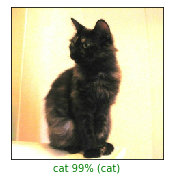

In [37]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Create a file to save the labels.

In [38]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

If you are running this notebook in a Colab, you can run the cell below to download the model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [39]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

# Prepare the Test Images for Download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [40]:
!mkdir -p test_images

In [41]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [42]:
!ls test_images

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [43]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/

'zip' is not recognized as an internal or external command,
operable program or batch file.


If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [44]:
try:
    files.download('cats_vs_dogs_test_images.zip')
except:
    pass